# Option Pricing with Cointegrated Assets

### Notebook by [Marco Tavora](https://marcotavora.me/)

## Table of contents

1. [Introduction](#Introduction)

## Introduction
[[go back to the top]](#Table-of-contents)

A simple model for option hedging based on cointegrated vectors is:

\begin{eqnarray}
&& \ln \left( {\frac{{S_t^{(i)}}}{{S_{t - 1}^{(i)}}}} \right) = {r_f} - d_t^{(i)} - \frac{1}{2}{(\sigma _t^{(i)})^2} + {\eta _i}\sigma _t^{(i)} + z_{t - 1}^{(j)}{\xi _i} + \vec \sigma _t^{(i)} \cdot \varepsilon _t^{(i)} \nonumber\\
&&{{\vec \sigma }_t} = {{\vec \beta }_0} + ({{\vec \beta }_1} + {{\vec \beta }_2}||{{\vec \varepsilon }_{t - 1}} - \vec \theta |{|^2}) \cdot \vec \sigma _{t - 1}^2\nonumber\\
&&{z_t} = \alpha + \beta t+ {\gamma _1}\ln (S_t^{(1)}) + {\gamma _2}\ln (S_t^{(2)})
\end{eqnarray}


The inclusion of a *stationary* process ${z_t}$ presupposes that in the long-run, stationarity is eventually achieved. Note also that only one $\gamma_i$ is independent due to cointegration parametric invariance. The volatility is a simple GARCH(1,1) process. To control for growth and violation of mean reverting behavior, we added a deterministic term to ${z_t}$ process.

## Conceptual Bird's Eye Review
[[go back to the top]](#Table-of-contents)

### Vector Error Correction Model VECM

The VECM model is given by:

$$\,\left[ {\begin{array}{*{20}{c}}
{\Delta {y_{1,t}}}\\
{\Delta {y_{2t}}}
\end{array}} \right] = \left[ {\begin{array}{*{20}{c}}
{{\gamma _{01}}}\\
{{\gamma _{02}}}
\end{array}} \right] + \left[ {\begin{array}{*{20}{c}}
{{\alpha _1}}\\
{{\alpha _2}}
\end{array}} \right]\left[ {{\beta _0}\,\,\,{\beta _1}\,\,\,{\beta _2}} \right]\left[ {\begin{array}{*{20}{c}}
1\\
{{y_{1,t - 1}}}\\
{{y_{2,t - 1}}}
\end{array}} \right] + \left[ {\begin{array}{*{20}{c}}
{{\gamma _{11}}}&{{\gamma _{21}}}\\
{{\gamma _{12}}}&{{\gamma _{22}}}
\end{array}} \right]\,\,\left[ {\begin{array}{*{20}{c}}
{\Delta {y_{1,t - 1}}}\\
{\Delta {y_{2,t - 1}}}
\end{array}} \right] + \left[ {\begin{array}{*{20}{c}}
{{\gamma _{31}}}&{{\gamma _{41}}}\\
{{\gamma _{32}}}&{{\gamma _{42}}}
\end{array}} \right]\,\,\left[ {\begin{array}{*{20}{c}}
{\Delta {y_{1,t - 2}}}\\
{\Delta {y_{2,t - 2}}}
\end{array}} \right] + \left[ {\begin{array}{*{20}{c}}
{{\nu _{1,t}}}\\
{{\nu _{2,t}}}
\end{array}} \right]$$

where we ${y_{1,t}}$ is the SPY and ${y_{1,t}}$ is the SHY. If both series are cointegrated, this information is included in the model via the error correction terms:

$${\alpha _i}({\beta _0}\, + {\beta _1}{y_{1,t - 1}}\, + {\beta _2}{y_{2,t - 1}}),\,\,\,\,\,i = 1,2$$

where 

$$({\beta _0}\, + {\beta _1}{y_{1,t - 1}}\, + {\beta _2}{y_{2,t - 1}}),\,\,\,\,\,i = 1,2$$

corresponds to the long-run. If in the long-run the last equation is zero we have the folowing relation:

$$\,{y_{2,t - 1}} =  - ({\beta _0}/{\beta _2})\, - ({\beta _1}/{\beta _2}){y_{1,t - 1}}$$

Hence, the $\beta$s we obtain after fitting the VECM inform us about the equilibrium relationship between the time series. When the two series deviate from equilibrium, the $\alpha$s "push them back".

We will choose $y_1$ and $y_2$ to be the following time series:
- SPY (the S&P 500 exchange traded fund)
- SHY (iShares 1-3 year Treasury Bond) prices. 

In [3]:
# install.packages('ggplot2')
# install.packages('xts')
# install.packages('quantmod')
# install.packages('broom')
# install.packages('tseries')
# install.packages("kableExtra")
# install.packages("knitr")
# install.packages("vars")
# install.packages("urca")

To load the data we will use the library `quantmod` which contains the function `getSymbols`. 

From the [documents](https://www.rdocumentation.org/packages/quantmod/versions/0.4-13/topics/getSymbols)

> getSymbols is a wrapper to load data from various sources, local or remote.

In our case we will load data from Yahoo Finance.

In [49]:
rm(list=ls()) 
library(tseries)
library(dynlm)
library(vars)
library(nlWaldTest) 
library(lmtest)
library(broom) 
library(car)
library(sandwich)
library(knitr)
library(forecast) 

In [53]:
library(quantmod)
setSymbolLookup(SHY='yahoo',SPY='yahoo')
getSymbols(c('SHY','SPY'))  

[1] "SHY" "SPY"

Defining `y1` and `y2` as the adjusted prices and joining them:

In [54]:
y1 <- SPY$SPY.Adjusted
y2 <- SHY$SHY.Adjusted
time_series <- cbind(y1, y2)
print('Our dataframe is:')
colnames(time_series) <- c('SHY', 'SPY') 
head(time_series)

[1] "Our dataframe is:"


                SHY      SPY
2007-01-03 111.6693 68.01018
2007-01-04 111.9062 68.07811
2007-01-05 111.0136 68.03567
2007-01-08 111.5271 67.99307
2007-01-09 111.4323 68.01858
2007-01-10 111.8035 68.00159

We can check for stationary of the series individually:

In [58]:
adf.test(time_series$SHY)
adf.test(time_series$SPY)


	Augmented Dickey-Fuller Test

data:  time_series$SHY
Dickey-Fuller = -1.5363, Lag order = 14, p-value = 0.7747
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  time_series$SPY
Dickey-Fuller = -3.7478, Lag order = 14, p-value = 0.02158
alternative hypothesis: stationary


In [57]:
print('p-values:')
adf.test(time_series$SHY)$p.value
adf.test(time_series$SPY)$p.value

[1] "p-values:"


[1] 0.7746659

[1] 0.02158483

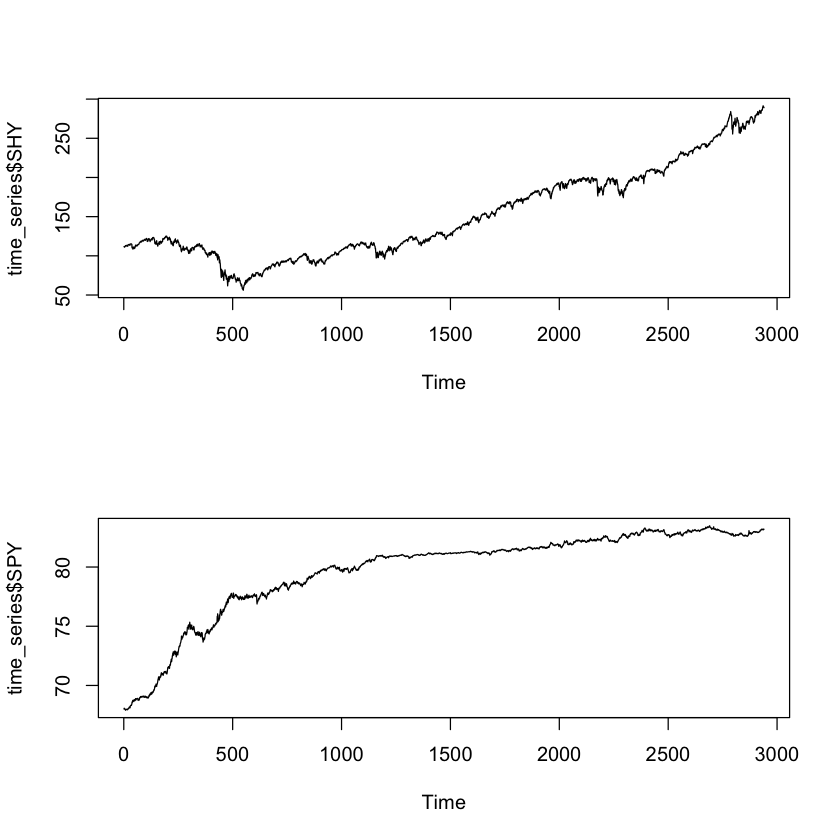

In [46]:
par(mfrow = c(2,1))
plot.ts(time_series$SHY,
        type='l')
plot.ts(time_series$SPY, 
        type='l')

### Johansen Test for Cointegration

The most well known cointegration test is the Johansen test which estimates the VECM parameters and determines whether the determinant of 

$$\alpha \beta = \left[ {\begin{array}{*{20}{c}}
{{\alpha _1}}\\
{{\alpha _2}}
\end{array}} \right]\left[ {{\beta _0}\,\,\,{\beta _1}\,\,\,{\beta _2}} \right]$$


is zero or not. If $\alpha \beta\neq 0$, the series are cointegrated.

In [31]:
library(urca)

In [32]:
johansentest <- ca.jo(time_series, type = "trace", ecdet = "const", K = 3)
summary(johansentest)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , without linear trend and constant in cointegration 

Eigenvalues (lambda):
[1] 2.248927e-02 3.620157e-03 4.437196e-18

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 1 | 10.65  7.52  9.24 12.97
r = 0  | 77.46 17.85 19.96 24.60

Eigenvectors, normalised to first column:
(These are the cointegration relations)

             SHY.l3      SPY.l3  constant
SHY.l3      1.00000      1.0000   1.00000
SPY.l3    -84.59851    163.3147  -8.78908
constant 6927.78683 -12622.5372 543.67420

Weights W:
(This is the loading matrix)

            SHY.l3        SPY.l3      constant
SHY.d 2.147229e-05  1.049741e-04 -1.531138e-17
SPY.d 2.088562e-05 -1.870590e-06  1.148836e-17


The lines $r=0$ and $r\le 1$ are the results of the test. More specifically:

- line $r=0$: these are the results of the hypothesis test with null hypothesis $r=0$. More concretely, this test checks if the matrix has zero rank. In the present case the hypothesis is rejected since the test variable is well above the $1\%$ value;
- line $r\le 1$: these are the results of the hypothesis test $r\le 1$. Now since the test value is below the $1\%$ value value we fail to reject the null hypothesis. Hence we conclude that the rank of $\alpha \beta$ is 1 and therefore the two series are cointegrated and we can use the VECM model.

Note that if hypotheses were reject we would have $r=2$ corresponding to two stationary series.

### Fitting the VECM

In [37]:
t <- cajorls(johansentest, r = 1)
t

$rlm

Call:
lm(formula = substitute(form1), data = data.mat)

Coefficients:
         SHY.d       SPY.d     
ect1      2.147e-05   2.089e-05
SHY.dl1  -4.754e-02   6.806e-04
SPY.dl1   5.658e-01  -1.192e-01
SHY.dl2  -6.092e-02   4.440e-04
SPY.dl2   3.243e-02  -6.055e-02


$beta
               ect1
SHY.l3      1.00000
SPY.l3    -84.59851
constant 6927.78683


The $\beta$ coefficients are given above. The $\gamma$ coefficients are above the $beta$s in the output.

## TO BE CONTINUED